## check gammapy version

In [1]:
import gammapy
gammapy.__version__

'1.1'

## some imports

In [2]:
import os
import glob

In [3]:
from astropy import units as u

from astropy.coordinates import SkyCoord, Angle

## set position, search radius and data location

The next line points to the location of the data files. It should point to a directory where the different configurations are saved in sub-directories.

In [4]:
basepath = 'C:/Users/User 1/Desktop/Honours Project/Real Data'

The next cell defines the source position and the search radius.

In [5]:
sourcepos = SkyCoord(83.633, 22.014, unit="deg", frame='icrs')

selectradius = 2.5*u.deg

## select the analysis configuration

The following cell lists all available configurations with their respective number.

In [6]:
analysis_configs = os.listdir(basepath)

c = 0

for i in analysis_configs :

    print('{}. {}'.format(c, i))
    
    c+=1

0. ModelPlus_HESSI_Stereo_Faint
1. ModelPlus_HESSI_Stereo_Std
2. ModelPlus_HESS_Combined_Stereo_Faint
3. ModelPlus_HESS_Combined_Stereo_Std


Choose a selection and put the number in the next cell. Note that the numbers may change when more configurations are added.

In [7]:
conf = analysis_configs[3]

In [8]:
print('You have chosen configuration {}.'.format(conf))

You have chosen configuration ModelPlus_HESS_Combined_Stereo_Std.


## cone search, run list and preparation of observations

In [9]:
os.environ['HESS_FITS'] = basepath

In [10]:
path = os.path.join(basepath, conf)

In [11]:
from gammapy.data import DataStore

In [12]:
data_store = DataStore.from_dir(path)

In [13]:
conesearch = data_store.obs_table.select_sky_circle(sourcepos, selectradius)

In [14]:
import numpy as np

The runs have different telescope configurations. Each number stands for one telescpe, 1 - 4 being the small telescopes and 5 the large telescope:

In [15]:
# np.unique(conesearch['TELLIST'])

We want only the runs containing all telescopes:

In [16]:
# telsearch = conesearch[conesearch['TELLIST'] == '1,2,3,4,5']

In [17]:
runlist = conesearch['OBS_ID'].value
# runlist = telsearch['OBS_ID'].value

The run list is:

In [18]:
print(runlist)

[127988 142427 135666 125793 103847 135520 100554 143213 100454 142463
  88973 142653 142563 127957  90238  90378  88951 142758 143210  79858
 142896  90349 127989  90441 142666 125719  90318 135158 127504  90376
 142760 143212  90408  90320  79882 135159 103850 142636  89828 126538
 142565  90203  90564 127954 101295 135307 142627 142629 142669 142568
  79885 101451 142989 127544 135246 142667  88986  90239  90348 142510
  79881 142650  90381 102575  90415 135270 125757  90439  90317 126116
 143050 135273 103806 100555 127956  90278  90380  90321 101320 127825
 100573  90277 142654  79859 128017 135635 135634 135481 144012  82038
 127958 103803 102988  80126  90410 103957 101135 127990 100452 143137
 142462 135271 126535 136480  79862  90377 103738 135480 126540 142590
 101071  79556 154376 142430  90275 103698 127503 100553 135521 128016
  79884 125717 103848  89732  82782 143211 143134 103849  90382 102293
  90319  82725 142668 101166 142630 126115 125716  90352 102576 142588
 14401

Now we get the observations for these runs:

In [19]:
observations = data_store.get_observations(runlist)

## Analysis

### Imports

In [20]:
import matplotlib.pyplot as plt
from IPython.display import display
from regions import CircleSkyRegion
import scipy.stats
from pathlib import Path

from gammapy.makers import MapDatasetMaker, FoVBackgroundMaker
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
    RingBackgroundMaker,
)

from gammapy.estimators import (
    ExcessMapEstimator,
    FluxPointsEstimator,
)

from gammapy.maps import Map, WcsGeom, WcsNDMap, RegionGeom, MapAxis
from gammapy.datasets import MapDatasetOnOff
from gammapy.datasets import MapDataset
from gammapy.data import EventList
from gammapy.modeling import Fit
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
)

from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PointSpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)

from gammapy.visualization import plot_spectrum_datasets_off_regions

### Dictionary for final results

Firstly I create a dictionary called final_results where I will save all of the results I get for analysis.

In [21]:
final_results = {}

### Defining the target region

The next cell selects the region of interest

In [22]:
on_region = CircleSkyRegion(center=sourcepos, radius=Angle("0.05 deg"))

### Creating an exclusion mask

The next cell creates an exclusion mask to make sure that the off regions don't contain any gamma-ray emission and then it shows the plot of the exclusion mask.

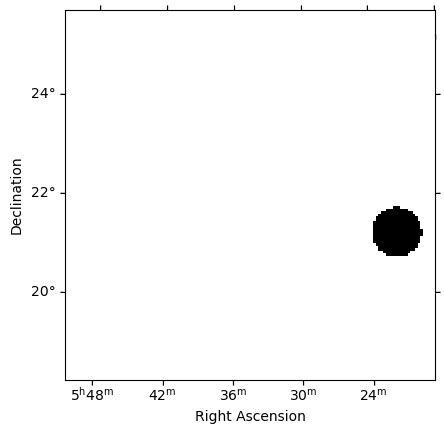

In [23]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5 * u.deg,
)

skydir = sourcepos.galactic
geom = WcsGeom.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~geom.region_mask([exclusion_region])
exclusion_mask.plot()
plt.show()

### Run data reduction chain

In the next cell we create the configuration of the maker classes. This includes thhe dataset maker, the background maker and also the safe mask maker

In [24]:
#We create the configuration of the maker classes
energy_axis = MapAxis.from_energy_bounds(
0.1, 40, nbin=10, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

#We create a spectrum dataset
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

We then input the empty spectrum dataset with the necessary data.

In [25]:
datasets = Datasets()

for obs_id, observation in zip(runlist, observations):
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

The next cell shows the plot of the regions.

C:\Users\User 1\anaconda3.1\envs\gammapy-1.0.1\lib\site-packages\regions\shapes\circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


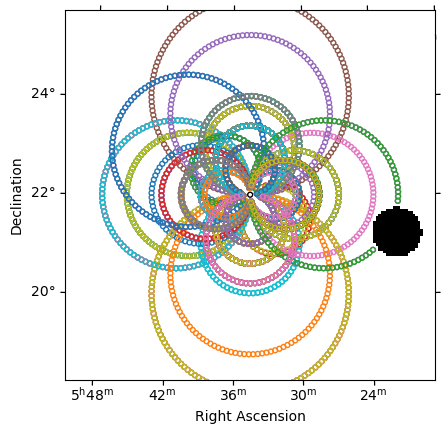

In [26]:
plt.figure()
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)
plt.show()

#### Source statistic

Below is the table containing the overall results of our signal region.

In [27]:
info_table = datasets.info_table(cumulative=True)

In [28]:
final_results['excess'] = info_table[-1]['excess']
final_results['significance'] = info_table[-1]['sqrt_ts']

The next cell is to show the excess and theta square plots.

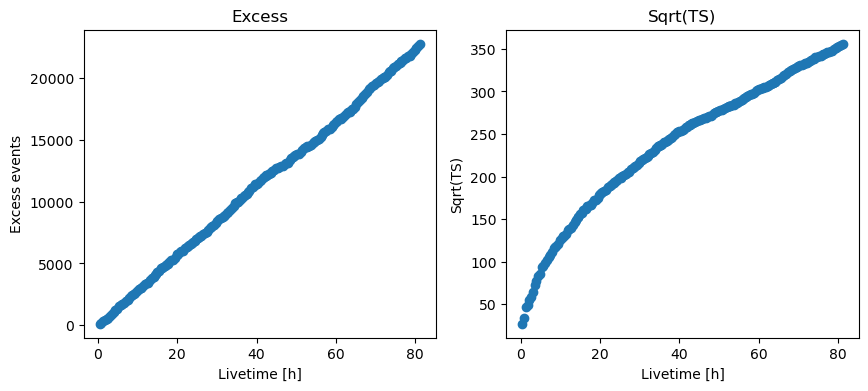

In [29]:
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")
plt.show()

### Spectrum Fit

We will start with the Power Law Spectral model to see if is it a good model and compare it with the Exponential Cut Off Power Law Spectral Model to see which one is the best spectral model for this data.

###### Power Law Spectral Model

In [30]:
spectral_model_1 = PowerLawSpectralModel(
    index=2,
    amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
model_1 = SkyModel(spectral_model=spectral_model_1, name="crab_1")

datasets.models = [model_1]

fit_joint_1 = Fit()
result_joint_1 = fit_joint_1.run(datasets=datasets)

#We make a copy of the model to compare it later and we also copy the likelihood of the fit.
model_best_PL = model_1.copy(name='crab_1')
L_PL = result_joint_1.total_stat

Details about the model

In [31]:
print(model_1)

SkyModel

  Name                      : crab_1
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.340   +/-    0.01             
    amplitude                     :   4.12e-11   +/- 2.8e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         




Checking if the fit terminated successfully

In [32]:
print(result_joint_1)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 56
	total stat : 6071.15

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



Showing the likelihood and the parameters of this model.

In [33]:
print(print('\nlikelihood = ', L_PL))
display(result_joint_1.models.to_parameters_table())


likelihood =  6071.148306858092
None


model,type,name,value,unit,error,min,max,frozen,is_norm,link
str6,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
crab_1,spectral,index,2.3404e+00,,8.226e-03,nan,nan,False,False,
crab_1,spectral,amplitude,4.1163e-11,cm-2 s-1 TeV-1,2.755e-13,nan,nan,False,True,
crab_1,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


Showing the plot of the spectrum and the residuals

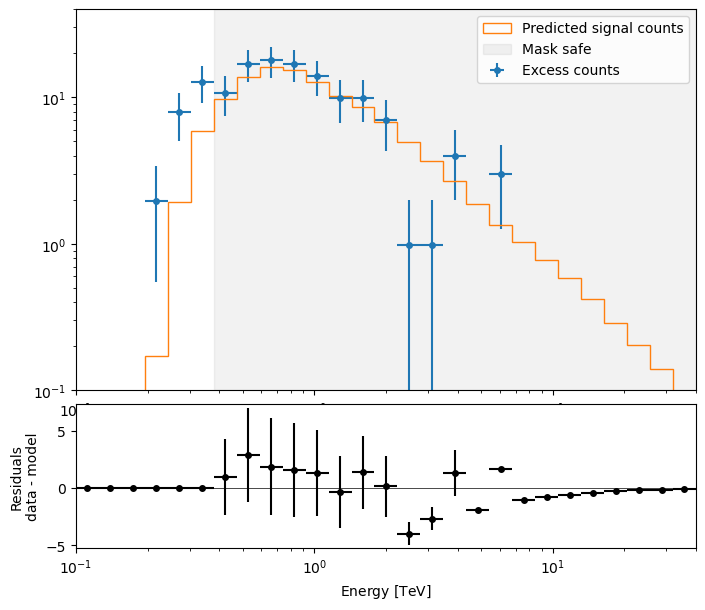

In [34]:
ax_spectrum, ax_residuals = datasets[0].plot_fit()
ax_spectrum.set_ylim(0.1, 40)
datasets[0].plot_masks(ax=ax_spectrum)
plt.show()

###### Exponential Cut Off Power Law Spectral Model

In [35]:
spectral_model_2 = ExpCutoffPowerLawSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2,
    lambda_=0.1 * u.Unit("TeV-1"),
    reference=1 * u.TeV,
)
model_2 = SkyModel(spectral_model=spectral_model_2, name="crab_2")

datasets.models = [model_2]

fit_joint_2 = Fit()
result_joint_2 = fit_joint_2.run(datasets=datasets)

model_best_expPL_2 = model_2.copy()
L_expPL = result_joint_2.total_stat

C:\Users\User 1\anaconda3.1\envs\gammapy-1.0.1\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Details about the model

In [36]:
print(model_2)

SkyModel

  Name                      : crab_2
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.116   +/-    0.02             
    amplitude                     :   4.75e-11   +/- 5.5e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.099   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   




Checking if the fit terminated successfully

In [37]:
print(result_joint_2)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully..
	nfev       : 164
	total stat : 5769.52

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



Showing the likelihood and the parameters of this model.

In [38]:
print('\nlikelihood = ', L_expPL)
display(result_joint_2.models.to_parameters_table())


likelihood =  5769.518721219624


model,type,name,value,unit,error,min,max,frozen,is_norm,link
str6,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
crab_2,spectral,index,2.1159e+00,,1.640e-02,nan,nan,False,False,
crab_2,spectral,amplitude,4.7494e-11,cm-2 s-1 TeV-1,5.520e-13,nan,nan,False,True,
crab_2,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
crab_2,spectral,lambda_,9.9408e-02,TeV-1,6.888e-03,nan,nan,False,False,
crab_2,spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,


Showing the plot of the spectrum and the residuals

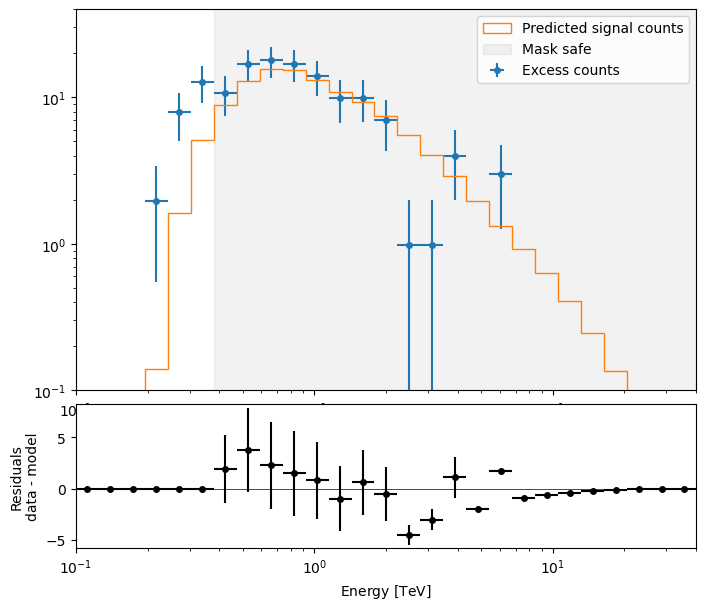

In [39]:
ax_spectrum, ax_residuals = datasets[0].plot_fit()
ax_spectrum.set_ylim(0.1, 40)
datasets[0].plot_masks(ax=ax_spectrum)
plt.show()

Now we check which model is best to fit the data

In [40]:
print(L_PL, L_expPL)
TS = 2*(L_PL-L_expPL)
print(TS)
P = scipy.stats.chi2.sf(TS,1)
print('probabilty: ',P)
print('significant?', P < 2.7e-3)
if P < 2.7e-3:
    print('Exponential Cut off Power Law model is accepted')
else :
    print('Straight power law is accepted')

6071.148306858092 5769.518721219624
603.2591712769354
probabilty:  3.2727024310285803e-133
significant? True
Exponential Cut off Power Law model is accepted


In [41]:
if P < 2.7e-3:
    bestmodel = model_best_expPL_2
else:
    bestmodel =model_best_PL

Details about the best model for our data fitting

In [42]:
print(bestmodel)

SkyModel

  Name                      : PCanhI6x
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.116   +/-    0.02             
    amplitude                     :   4.75e-11   +/- 5.5e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.099   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   




Saving the parameters of the best model and the type of the model into the final results dictionary.

In [43]:
datasets.models = bestmodel
final_results['fit parameters'] = bestmodel.parameters.to_table()
final_results['model type'] = bestmodel.spectral_model.tag

### Spectrum Points

Now we create the spectrum points for the best fit model

In [44]:
e_min, e_max = 0.5, 50
energy_edges = np.geomspace(e_min, e_max, 11) * u.TeV

In [45]:
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source=bestmodel.name, selection_optional="all"
)
flux_points = fpe.run(datasets=datasets)

The next cell shows the table of the resulting flux points.

In [46]:
flux_table = flux_points.to_table(sed_type="dnde", formatted=True)
flux_table

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[209],float32[209],float64,bool,float64[209],bool,float64[11],float64[11]
0.590,0.473,0.737,1.318e-10,1.829e-12,1.837e-12,1.820e-12,1.355e-10,28982.250,170.242,27.95822678749343 .. 40.403154343142305,27.576645 .. 39.84708,1082.092,False,35.0 .. 39.0,True,0.200 .. 5.000,8964.279 .. 27735.455
0.920,0.737,1.148,5.191e-11,7.164e-13,7.196e-13,7.131e-13,5.336e-11,30808.247,175.523,28.818052433434886 .. 34.871475123587715,28.698383 .. 34.58373,701.640,False,31.0 .. 28.0,True,0.200 .. 5.000,9037.051 .. 25839.583
1.434,1.148,1.790,2.006e-11,3.136e-13,3.152e-13,3.120e-13,2.069e-11,24136.929,155.361,21.26731328171674 .. 25.31678840864935,21.071793 .. 25.11493,608.121,False,20.0 .. 33.0,True,0.200 .. 5.000,7352.619 .. 18930.516
2.497,1.790,3.483,5.181e-12,8.821e-14,8.870e-14,8.771e-14,5.360e-12,19452.048,139.471,16.55892840107341 .. 20.222578938609146,16.494003 .. 19.912413,733.376,False,9.0 .. 17.0,True,0.200 .. 5.000,5994.883 .. 18277.485
4.348,3.483,5.429,1.369e-12,4.117e-14,4.158e-14,4.077e-14,1.453e-12,5799.686,76.156,4.8501010009133605 .. 6.021406285289418,4.817518 .. 5.95321,516.830,False,4.0 .. 7.0,True,0.200 .. 5.000,2220.749 .. 5919.957
6.778,5.429,8.462,4.127e-13,1.845e-14,1.871e-14,1.818e-14,4.506e-13,2438.243,49.379,2.1978800516913504 .. 2.8586695679624707,2.19788 .. 2.771142,510.221,False,3.0 .. 1.0,True,0.200 .. 5.000,1256.989 .. 3048.784
10.564,8.462,13.189,1.156e-13,7.681e-15,7.847e-15,7.523e-15,1.317e-13,1020.541,31.946,1.087899819574798 .. 1.3702945819049195,1.0556418 .. 1.3702946,448.538,False,0.0 .. 2.0,True,0.200 .. 5.000,792.575 .. 1530.110
16.465,13.189,20.556,2.942e-14,2.813e-15,2.901e-15,2.727e-15,3.540e-14,447.769,21.161,0.45401776345317 .. 0.7187219571119874,0.45401776 .. 0.69588566,318.255,False,0.0 .. 1.0,True,0.200 .. 5.000,513.604 .. 709.171


Below is the plot of the flux points and their likelihood profiles.

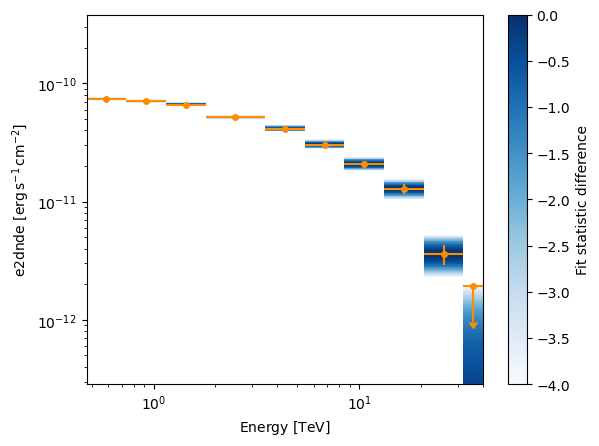

In [47]:
fig, ax = plt.subplots()
flux_points.plot(ax=ax, sed_type="e2dnde", color="darkorange")
flux_points.plot_ts_profiles(ax=ax, sed_type="e2dnde")
plt.show()

Below is the final plot with the best fit model, the fulx points and residuals.

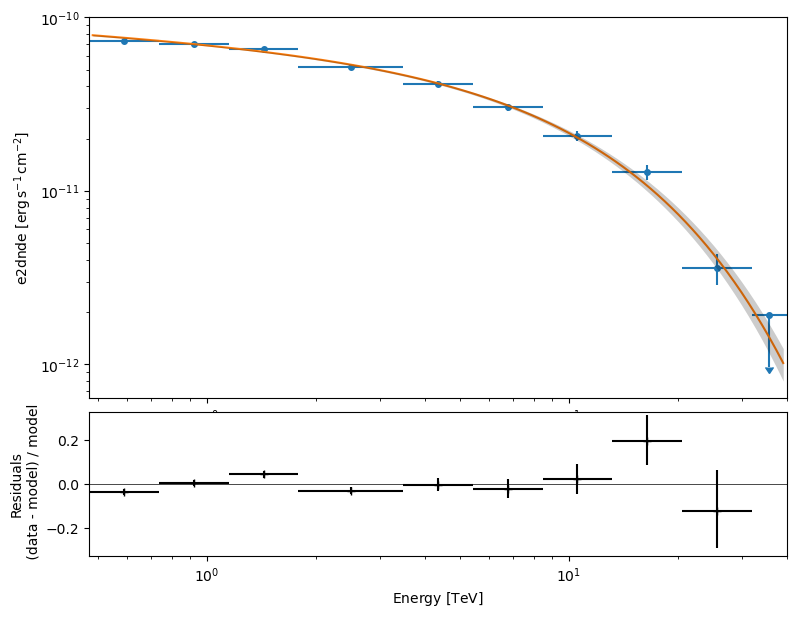

In [48]:
flux_points_dataset = FluxPointsDataset(data=flux_points, models=bestmodel)
flux_points_dataset.plot_fit()
plt.show()

I now store the flux points into the final results dictinary.

In [49]:
final_fluxpoints = flux_table['e_ref', 'e_min', 'e_max', 'dnde_err','counts']
final_results['flux points'] = final_fluxpoints

## Summary of the results

In [50]:
print('I have detected an excess of {:4.1f} gamma rays with a statistical significance of {:3.1f} sigma.'.format(final_results['excess'], final_results['significance']))
print('The spectrum is best described by a {:s}.'.format(final_results['model type'][0]))
print('The best fit parameters are:\n', final_results['fit parameters'])
print('The spectral data points are:\n', final_results['flux points'])

I have detected an excess of 22805.7 gamma rays with a statistical significance of 356.0 sigma.
The spectrum is best described by a ExpCutoffPowerLawSpectralModel.
The best fit parameters are:
   type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral     index 2.1159e+00                ... nan  False   False     
spectral amplitude 4.7494e-11 cm-2 s-1 TeV-1 ... nan  False    True     
spectral reference 1.0000e+00            TeV ... nan   True   False     
spectral   lambda_ 9.9408e-02          TeV-1 ... nan  False   False     
spectral     alpha 1.0000e+00                ... nan   True   False     
The spectral data points are:
 e_ref  e_min  e_max      dnde_err       counts   
 TeV    TeV    TeV   1 / (cm2 s TeV)             
------ ------ ------ --------------- ------------
 0.590  0.473  0.737       1.829e-12 35.0 .. 39.0
 0.920  0.737  1.148       7.164e-13 31.0 .. 28.0
 1.434  1.148 